In [2]:
import xgboost
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import warnings

from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

import matplotlib.pyplot as pyplot
from sklearn.calibration import calibration_curve
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')

In [5]:
orders[orders['user_id'] == 119909].head(1)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1995637,309714,119909,prior,1,1,12,0.0


In [3]:
products  = pd.read_csv('../data/products.csv')
aisles = pd.read_csv('../data/aisles.csv')
departments = pd.read_csv('../data/departments.csv')
orders = pd.read_csv('../data/orders.csv')
prior_order = pd.read_csv('../data/order_products__prior.csv')
train_order =  pd.read_csv('../data/order_products__train.csv')
orders.fillna(value = 0, inplace = True)

In [3]:
# merge data set

prior_train_order = prior_order.sort_values(by=['order_id'])



prior_train_order = pd.merge(left = prior_train_order, right= products,
                             on = 'product_id').sort_values(by='order_id').reset_index(drop= True)
prior_train_order = pd.merge(left = prior_train_order , right = aisles ,
                              on='aisle_id').sort_values(by='order_id').reset_index(drop= True)
prior_train_order = pd.merge(left = prior_train_order, right = departments,
                              on = 'department_id').sort_values(by='order_id').reset_index(drop= True)
prior_train_order = pd.merge(left = prior_train_order, right = orders,
                              on = 'order_id').sort_values(by='order_id').reset_index(drop= True)
#del prior_train_order

In [179]:
prior_train_order.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,1819,8,1,All Natural No Stir Creamy Almond Butter,88,13,spreads,pantry,202279,prior,3,5,9,8.0
2,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
3,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
4,2,17794,6,1,Carrots,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0


In [181]:
#del prior_train_order

import gc
gc.collect()

2075

In [118]:
#prior_orders_data = pd.concat([prior_order, train_order]).sort_values(by=['order_id'])
#prior_orders_data = pd.merge(left = prior_orders_data, right = products,3
#                            left_on='product_id', right_on='product_id').sort_values(by=['order_id']).reset_index(drop=True)
#prior_orders_data = pd.merge(left = prior_orders_data, right = aisles,
#                            left_on='aisle_id', right_on='aisle_id').sort_values(by=['order_id']).reset_index(drop=True)
#prior_orders_data = pd.merge(left = prior_orders_data, right = departments,
#                        left_on='department_id', right_on='department_id').sort_values(by=['order_id']).reset_index(drop=True)
#prior_orders_data = pd.merge(left = prior_orders_data, right = orders,
#                             left_on='order_id', right_on='order_id').sort_values(by=['order_id']).reset_index(drop=True)

#prior_orders_data.head()

In [ ]:
prior_train_order.groupby(["user_id","product_id"]).size().shape[0]/prior_train_order.shape[0]

In [80]:
print("Shape of prior_orders_data :", prior_train_order.shape)

Shape of prior_orders_data : (33819106, 15)


In [82]:
print("Shape of prior_orders_data :", prior_orders_data.shape)

Shape of prior_orders_data : (33819106, 15)


In [8]:
print("Shape of product :", products.shape)
print("Shape of prior_order :", prior_order.shape)
print("Shape of train_order :", train_order.shape)
print("Shape of orders :", orders.shape)

Shape of product : (49688, 4)
Shape of prior_order : (32434489, 4)
Shape of train_order : (1384617, 4)
Shape of orders : (3421083, 7)


In [6]:
def generate_product_features(prior_data = None):
    
    """ Generate Product based fearues and return it as dataframe object
    
    Features:
    feat_1 : product_reorder_rate  : How frequently the product was reordered ?
    feat_2 : avg_pos_in cart       : Average position of product in the cart
    
    #reduce sparsity using NMF
    #ref:https://www.kaggle.com/themissingsock/matrix-decomposition-with-buyer-data
    
    Next we will category each products in different categorya and then reduce them to 3 columns using NFM : 
    feat_3 : p_reduced_feat_1             : column 1 from NMF output
    feat_4 : p_reduced_feat_2             : column 2 from NMF output
    feat_5 : p_reduced_feat_3             : column 3 from NMF output
    
    
    feat_6 : aisle_reorder_rate           : How frequently a product is reordered from the aisle to which this product belongs
    feat_7 : department_reorder_rate      : How frequently a product is reordered from the department to which this product belongs
        
    """
    product_features = pd.DataFrame(columns=['product_id'])    
    product_features['product_id']= prior_data['product_id'].sort_values().unique()
    
    # this gives reorder rate 
    df = pd.DataFrame({'reorder_rate': prior_data.groupby(['product_id','reordered'])['reordered'].\
                                                       count().groupby(level=0).\
                                                       apply(lambda x: x / float(x.sum()))}).\
                                                       reset_index(level=1, drop=True).reset_index()
       
    #handling for products which were never reordered, hence reorder_rate = 0.0
    #get data of reordered products only
    new_df = df[df['reordered']==1]
    print(new_df.shape)
    new_df['reorder_rate'] = new_df['reorder_rate'] * new_df['reordered']
    
    #handling for products which were never reordered, hence reorder_rate = 0.0
    new_df_1 = df[(df['reordered']==0) & (df['reorder_rate']==float(1.0))]
    new_df_1['reorder_rate'] = new_df_1['reorder_rate'] * new_df_1['reordered']
    new_df = pd.concat([new_df,new_df_1])
    print(new_df.shape)
    print(new_df_1.shape)
    
    #drop other columns of the new_df and sort values by product name to align with product features dataframe
    new_df.drop('reordered', axis = 1, inplace = True)
    new_df.sort_values(by='product_id', inplace =  True)   
    new_df = new_df.reset_index(drop = True)
    
    #add to feat_1 of product_features dataframe
    product_features['product_reorder_rate'] = new_df['reorder_rate']
    
    #get mean position of product in the cart, sort by product_name and add to feat_2 of product_features
    mean_position = prior_data.groupby('product_id')['add_to_cart_order'].\
                               mean().reset_index(name = 'mean_position')
    mean_position.sort_values(by = 'product_id', inplace = True)
    product_features['avg_pos_incart'] = mean_position['mean_position']
    
    #generate boolean values if product belongs to below categories
    products['isOrganic'] = products['product_name'].apply(lambda x: 'organic' in x.lower()).astype(int)
    products['isYogurt'] = products['aisle_id'].apply(lambda x: x==120).astype(int)

    products['isProduce'] = products['department_id'].apply(lambda x: x==4).astype(int)
    products['isFrozen'] = products['department_id'].apply(lambda x: x==1).astype(int)
    products['isdairy'] = products['department_id'].apply(lambda x: x==16).astype(int)
    products['isbreakfast'] = products['department_id'].apply(lambda x: x==14).astype(int)
    products['issnack'] = products['department_id'].apply(lambda x: x==19).astype(int)
    products['isbeverage'] = products['department_id'].apply(lambda x: x==7).astype(int)
    
    new_product_feat = products[['isOrganic', 'isYogurt', 'isProduce', 'isFrozen', 'isdairy', 'isbreakfast', 'issnack', 'isbeverage']]
    
    nmf = NMF(n_components = 3)
    model = nmf.fit(new_product_feat)
    W = model.transform(new_product_feat)
    prod_data = pd.DataFrame(normalize(W))
    
    prod_data.columns = ['p_reduced_feat_1', 'p_reduced_feat_2','p_reduced_feat_3']
    products.drop(['isOrganic', 'isYogurt', 'isProduce', 'isFrozen', 'isdairy', 'isbreakfast', 'issnack', 'isbeverage'], axis = 1, inplace =True)

    product_features['p_reduced_feat_1'] = prod_data['p_reduced_feat_1']
    product_features['p_reduced_feat_2'] = prod_data['p_reduced_feat_2']
    product_features['p_reduced_feat_3'] = prod_data['p_reduced_feat_3']
    
    #Get aisle reorder rate
    df = prior_train_order.groupby(['aisle']).size().reset_index(name='order_count')
    aisle_reorder_rate = prior_data[prior_data['reordered']==1].groupby(['aisle']).size().reset_index(name='reorder_rate')
    df['aisle_reorder_rate'] = aisle_reorder_rate['reorder_rate']/df['order_count']
    df.drop(['order_count'], axis = 1, inplace = True)
    new_df = pd.merge(prior_train_order, df, on = 'aisle')
    
    
    #Get dept reorder rate
    df = prior_train_order.groupby(['department']).size().reset_index(name='order_count')
    aisle_reorder_rate = prior_data[prior_data['reordered']==1].groupby(['aisle']).size().reset_index(name='reorder_rate')
    df['dept_reorder_rate'] = aisle_reorder_rate['reorder_rate']/df['order_count']
    df.drop(['order_count'], axis = 1, inplace = True)
    new_df = pd.merge(new_df, df, on = 'department')
    
    new_df = new_df[['product_id','aisle_id','department_id','aisle_reorder_rate','dept_reorder_rate']]
    new_df.drop_duplicates(keep='first', inplace = True)

    #merge dept_reorder_rate and aisle_reorder_rate to existing product features
    product_features = pd.merge(product_features, new_df , on='product_id', how = 'inner')
    
    del df, new_df, new_df_1, new_product_feat, model, prod_data
    return product_features
    

In [7]:
def generate_user_features(prior_data = None):
    """
     In this method we focus on users !!
     Features :
     feat_1 : user_reorder_rate              : Average reorder rate on orders placed?
     feat_2 : user_unique_products           : Distinct Products ordered ?
     feat_3 : user_total_products            : Total products ordered ?
     feat_4 : user_avg_cart_size             : mean Products per order ? = average cart size ?
     feat_5 : user_avg_days_between_orders   : Average days between orders ?
     feat_6 : user_reordered_products_ratio  : user product reorder ratio
     
    """
    
    user_features = pd.DataFrame(columns=['user_id'])
    
    #Add user_id
    user_features['user_id'] = prior_data['user_id'].sort_values().unique()
    user_reorder_rate = prior_data.groupby(["user_id","reordered"])['reordered'].count().groupby(level = 0).\
                            apply(lambda x: x / float(x.sum())).\
                            reset_index(level=1, drop=True).\
                            reset_index(name='reorder_rate')
    user_reorder_rate = user_reorder_rate.pivot(index ='user_id', columns ='reordered', values =['reorder_rate']) 
    user_reorder_rate = pd.DataFrame(user_reorder_rate.to_records())
    user_reorder_rate.columns = ['user_id','0', '1']
    user_reorder_rate.set_index("user_id", inplace = True)
    user_reorder_rate.fillna(0, inplace = True)
    user_reorder_rate.reset_index(inplace = True)
    user_features['user_reorder_rate'] = user_reorder_rate['1']
    
    #Get count of all unique products for every user
    user_features['user_unique_products'] = prior_data.groupby(["user_id"])['product_name'].nunique().reset_index(name = 'unique')['unique']
    
    #Get count of all products ordered by user
    user_features['user_total_products'] = prior_data.groupby(["user_id"])['product_name'].size().reset_index(name = 'count')['count']
    
    #Get mean products per user = Average cart size of user
    df = prior_train_order.groupby(["user_id","order_id"])['add_to_cart_order'].count().reset_index(name='cart_size')\
                                                                .groupby('user_id')['cart_size'].mean().reset_index()
    user_features['user_avg_cart_size'] = df['cart_size']
    
    #Get average days between 2 orders for every user
    df = prior_data.groupby(["user_id","order_id"])['days_since_prior_order'].max().reset_index(name='mean_days_between_orders')\
                                                                .groupby('user_id')['mean_days_between_orders'].mean().reset_index()
    user_features['user_avg_days_between_orders'] = df['mean_days_between_orders']
    
    #get user product reorder ratio 
    # number of unique products reordered / number of unique products ordered
    df['user_id'] = prior_data['user_id'].sort_values().unique()
    df['user_unique_products'] = prior_data.groupby(["user_id"])['product_name'].nunique().reset_index(name = 'unique')['unique']
    df['user_reordered_products'] = prior_data[prior_data['reordered']==1].groupby(["user_id"])['product_name'].nunique().reset_index(name = 'reordered_unique')['reordered_unique']
    df.fillna(0, inplace = True)
    user_features['user_reordered_products_ratio'] = df['user_reordered_products'] / df['user_unique_products']
    
    del df
    return user_features
    

In [8]:
%%time
product_features = generate_product_features(prior_data = prior_train_order )
product_features.to_csv("product_features_v6.csv",index=False)

(45305, 3)
(49677, 3)
(4372, 3)
CPU times: total: 1min 55s
Wall time: 1min 58s


In [15]:
product_features

,product_id,product_reorder_rate,avg_pos_incart,p_reduced_feat_1,p_reduced_feat_2,p_reduced_feat_3,aisle_id,department_id,aisle_reorder_rate,dept_reorder_rate
0,1,0.613391,5.801836,1.0,0.0,0.0,61,19,0.548698,0.043323
1,2,0.133333,9.888889,0.0,0.0,0.0,104,13,0.152391,0.031986
2,3,0.732852,6.415162,0.0,0.0,1.0,94,7,0.527615,0.000943
3,4,0.446809,9.507599,0.0,1.0,0.0,38,1,0.556655,0.006004
4,5,0.600000,6.466667,0.0,0.0,0.0,5,13,0.280627,0.031986
...,...,...,...,...,...,...,...,...,...,...
49672,49684,0.111111,4.333333,0.0,1.0,0.0,124,5,0.572344,0.039916
49673,49685,0.122449,9.571429,0.0,1.0,0.0,42,1,0.542171,0.006004
49674,49686,0.700000,7.500000,0.0,0.0,1.0,112,3,0.670168,0.003821
49675,49687,0.461538,7.538462,0.0,0.0,1.0,41,8,0.620883,1.763262


In [ ]:
%%time
user_features = generate_user_features(prior_data = prior_train_order)
user_features.to_csv("user_features_v6.csv",index=False)

In [ ]:
def max_streak(row):
    
    """
    Function to calculate the maximum number of orders in a row which contains reorders of a product
    
    This function is useful for analyzing user-product interactions
    and identifying the most extended streaks during which a product is reordered. 
    It can provide insights into user behavior and preferences.

    inp: pandas row
    output: max orders
    """
    _max = 0
    _sum = 0
    for i in row:
        if i==1:
            _sum += 1
        else:
            if _sum > _max:
                _max = _sum
            _sum = 0 
    return _max

In [ ]:
def hour_tocategorical(time):
    """
    convert hour of the day to categorical feature
    """
    if time > 5 and time < 12:
            return 0
    elif time > 12 and time < 17:
        return 1
    elif time > 17 and time < 21:
        return 2
    else:
        return 3
    

In [ ]:
def generate_user_product_features(prior_data = None):
     #create an empty dataframe
    user_product_features = pd.DataFrame(columns=['user_id','product_id'])
    
    #get unique user-product pairs ( total data is reduced by 60 %)
    #prior_train_orders.groupby(["user_id","product_id"]).size().shape[0]/prior_train_orders.shape[0]  - 0.409
    #add user and product to dataframe
    u_p = prior_data.groupby(["user_id","product_id"]).size().reset_index()
    user_product_features["user_id"] = u_p["user_id"]
    user_product_features["product_id"] = u_p["product_id"]
    
    #How frequently user ordered the product ?
    # #times user ordered the product/ #times user placed an order
    df = prior_data.groupby(["user_id","product_id"])["reordered"].size()
    df = df/prior_data.groupby(["user_id"]).size()
    df = df.reset_index(name = 'order_rate')
    df.fillna(0. , inplace = True)
    user_product_features["u_p_order_rate"] = df["order_rate"]
    
    #How frequently user reordered the product ?
    # #times user reordered the product/ #times user ordered the product
    df = prior_data[prior_train_order["reordered"]==1].groupby(["user_id","product_id"])["reordered"].size()
    df = df/prior_train_order.groupby(["user_id","product_id"]).size()
    df = df.reset_index(name = 'reorder_rate')
    df.fillna(0. , inplace = True)
    user_product_features["u_p_reorder_rate"] = df["reorder_rate"]
    
    #Average position of product in the cart on orders placed by user ?
    
    df = prior_data.groupby(["user_id","product_id"])['add_to_cart_order'].mean().reset_index(name = 'mean_position')
    user_product_features['u_p_avg_position'] = df['mean_position']

    
    #Number of orders placed since the product was last ordered ?
    # Get last order_number placed by user , subtract with last order_number with the product in cart 
    
    df = prior_data.groupby(["user_id","product_id"])['order_number'].max().reset_index()
    df_2 = prior_data.groupby(["user_id"])['order_number'].max().reset_index()
    new_df = pd.merge(df, df_2,  how='outer', left_on=['user_id'], right_on = ['user_id'])        
    new_df['order_diff'] = new_df['order_number_y'] - new_df['order_number_x']
    user_product_features['u_p_orders_since_last'] = new_df['order_diff']
    
    #max_streak
    df = prior_data.groupby(["user_id","product_id"])['reordered'].apply(list).reset_index(name = 'max_streak')
    df['max_streak'] = df['max_streak'].apply(max_streak)
    user_product_features = pd.merge(user_product_features, df, on= ["user_id","product_id"])
    #user_features["max_streak"] = df['reorder_summary'].apply(max_streak) 
    
    
    del df, new_df, df_2
    return user_product_features

In [ ]:
%%time
user_product_features = generate_user_product_features(prior_data = prior_train_order)
user_product_features.to_csv("user_product_features_prior_data_v6.csv",index=False)

In [ ]:
def product_time(prior_data = None):
    
    """
    feature : how frequently product was reordered on any given hour ?
    """
    df = prior_data.groupby(['product_id','order_hour_of_day'])["reordered"].size()
    df = df/prior_data.groupby(["product_id"]).size()
    df = df.reset_index(name = 'hour_reorder_rate')
    return df

def product_day(prior_data = None):
    """
    feature: how frequently product was reordered on any given day ?
    """
    df = prior_data.groupby(['product_id','order_dow'])["reordered"].size()
    df = df/prior_data.groupby(["product_id"]).size()
    df = df.reset_index(name = 'day_reorder_rate')
    return df

def product_days_since_prior(prior_data = None):
    """
    feature: how frequently a product was reordered  given that 
            difference between 2 orders containing product in days ?
    """
    df = prior_data.groupby(['product_id','days_since_prior_order'])["reordered"].size()
    df = df/prior_data.groupby(["product_id"]).size()
    df = df.reset_index(name = 'p_days_since_prior_order_reorder_rate')
    return df

def user_days_since_prior(prior_data = None):
    """
    feature: how frequently user reordered any product given difference between 2 orders in days ?
    """
    df = prior_data.groupby(['user_id','days_since_prior_order'])["reordered"].size()
    df = df/prior_data.groupby(["user_id"]).size()
    df = df.reset_index(name = 'u_days_since_prior_order_reorder_rate')
    return df

def u_p_days_since_prior(prior_data = None):
    """
    feature: how frequently user reordered a particular product given difference between 2 orders in days ?
    This information can be valuable for understanding how frequently products are reordered within specific time intervals and 
    can be used in various analyses and recommendation systems.
    
    """
    df = prior_data.groupby(["user_id","product_id","days_since_prior_order"])["reordered"].size()
    df = df/prior_data.groupby(["user_id","product_id"]).size()
    df = df.reset_index(name = 'days_since_prior_reorder_rate')
    return df

In [ ]:
#Calculate  hourly reorder rate, daily reorder rate , products reorder rate, users reorder rate
hour_reorder_rate = product_time(prior_train_order)
day_reorder_rate = product_day(prior_train_order)
p_days_since_prior_order_reorder_rate = product_days_since_prior(prior_train_order)
u_days_since_prior_order_reorder_rate = user_days_since_prior(prior_train_order)
days_since_prior_reorder_rate = u_p_days_since_prior(prior_train_order)

In [37]:
list3 = day_reorder_rate.sort_values(by='day_reorder_rate',ascending = False)['product_id'].head(5).tolist()
day_reorder_rate.sort_values(by='day_reorder_rate',ascending = False).head(5)


,product_id,order_dow,day_reorder_rate
43291,6771,6,1.0
287832,44982,1,1.0
145627,22747,0,1.0
308924,48276,6,1.0
143307,22391,2,1.0


In [39]:
products[products['product_id'].isin(list3)]

,product_id,product_name,aisle_id,department_id
6770,6771,Pork Spice Rub,5,13
22390,22391,IncrediBites for Small Dogs With Real Chicken ...,40,8
22746,22747,Vanilla Bean Sheep Milk Ice Cream,37,1
44981,44982,Coconut Bliss Pineapple Coconut,37,1
48275,48276,Natural Lavender Mint Creme Filled Dark Chocol...,45,19


In [20]:
#store data for further processing --storing as pickle file rather than csv
#hour_reorder_rate.to_csv("hour_reorder_rate.csv", index = False)
#day_reorder_rate.to_csv("day_reorder_rate.csv", index = False)
#p_days_since_prior_order_reorder_rate.to_csv("p_days_since_prior_order_reorder_rate.csv", index = False)
#u_days_since_prior_order_reorder_rate.to_csv("u_days_since_prior_order_reorder_rate.csv", index = False)
#days_since_prior_reorder_rate.to_csv("days_since_prior_reorder_rate.csv", index = False)

hour_reorder_rate.to_pickle("hour_reorder_rate.pkl")
day_reorder_rate.to_pickle("day_reorder_rate.pkl")
p_days_since_prior_order_reorder_rate.to_pickle("p_days_since_prior_order_reorder_rate.pkl")
u_days_since_prior_order_reorder_rate.to_pickle("u_days_since_prior_order_reorder_rate.pkl")
days_since_prior_reorder_rate.to_csv("days_since_prior_reorder_rate.pkl")

In [137]:
product_features = pd.read_csv("product_features_v6.csv")
user_features = pd.read_csv("user_features_v6.csv")
user_product_features = pd.read_csv("user_product_features_prior_data_v6.csv")

In [138]:
%%time
#merge all product ,user, user_product features with prior_last_orders

merged_df = pd.merge(user_product_features, user_features,  how='outer', left_on=['user_id'], right_on = ['user_id'])
merged_df = pd.merge(merged_df, product_features,  how='outer', left_on=['product_id'], right_on = ['product_id'])

CPU times: total: 6.88 s
Wall time: 6.93 s


In [139]:
#now merge all files  with training data set
train_order_data = train_order.sort_values(by=['order_id'])
train_order_data = pd.merge(left = train_order_data, right = products,
                             left_on='product_id', right_on='product_id').sort_values(by=['order_id']).reset_index(drop=True)
train_order_data = pd.merge(left = train_order_data, right = aisles,
                             left_on='aisle_id', right_on='aisle_id').sort_values(by=['order_id']).reset_index(drop=True)
train_order_data = pd.merge(left = train_order_data, right = departments,
                             left_on='department_id', right_on='department_id').sort_values(by=['order_id']).reset_index(drop=True)
train_order_data = pd.merge(left = train_order_data, right = orders,
                             left_on='order_id', right_on='order_id').sort_values(by=['order_id']).reset_index(drop=True)

col_order = ['user_id',
 'order_id',
 'product_id',
  'aisle_id',
 'department_id',
 'add_to_cart_order',
 'reordered',
 'product_name',
 'aisle',
 'department',
 'eval_set',
 'order_number',
 'order_dow',
 'order_hour_of_day',
 'days_since_prior_order']

train_order_data = train_order_data[col_order]
print("Shape of train_order_data :", train_order_data.shape)
train_order_data.head()

Shape of train_order_data : (1384617, 15)


,user_id,order_id,product_id,aisle_id,department_id,add_to_cart_order,reordered,product_name,aisle,department,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,112108,1,49302,120,16,1,1,Bulgarian Yogurt,yogurt,dairy eggs,train,4,4,10,9.0
1,112108,1,13176,24,4,6,0,Bag of Organic Bananas,fresh fruits,produce,train,4,4,10,9.0
2,112108,1,47209,24,4,7,0,Organic Hass Avocado,fresh fruits,produce,train,4,4,10,9.0
3,112108,1,10246,83,4,3,0,Organic Celery Hearts,fresh vegetables,produce,train,4,4,10,9.0
4,112108,1,43633,95,15,5,1,Lightly Smoked Sardines in Olive Oil,canned meat seafood,canned goods,train,4,4,10,9.0


In [140]:
upd_train_orders = train_order_data[['user_id','order_id','product_id','reordered']]
last_orders = upd_train_orders.groupby(['user_id'])['order_id'].max().reset_index(name = 'new_order_id')
order_details = train_order_data[['order_id','order_dow','order_hour_of_day','days_since_prior_order']]
order_details = order_details.drop_duplicates()

In [141]:
%%time
#merge training data set with  newly built features)

train_orders_merged_df = pd.merge(merged_df, upd_train_orders,  how='left', left_on=['user_id','product_id'], right_on = ['user_id','product_id'])
train_orders_merged_df = pd.merge(train_orders_merged_df, last_orders, on = 'user_id')
train_orders_merged_df.drop("order_id", axis = 1, inplace = True)
train_orders_merged_df.rename(columns = {'new_order_id':'order_id'}, inplace = True) 
train_orders_merged_df = pd.merge(train_orders_merged_df, order_details, on = 'order_id')
train_orders_merged_df[['reordered']]= train_orders_merged_df[['reordered']].fillna(value=0.0)

CPU times: total: 13.7 s
Wall time: 13.6 s


In [182]:
train_orders_merged_df.columns

NameError: name 'train_orders_merged_df' is not defined

In [142]:
%%time
#merge with misc features

train_orders_merged_df = pd.merge(train_orders_merged_df, hour_reorder_rate, on=['product_id','order_hour_of_day'], how = 'left')
train_orders_merged_df[['hour_reorder_rate']]= train_orders_merged_df[['hour_reorder_rate']].fillna(value=0.0)

train_orders_merged_df = pd.merge(train_orders_merged_df, day_reorder_rate, on=['product_id','order_dow'], how = 'left')
train_orders_merged_df[['day_reorder_rate']]= train_orders_merged_df[['day_reorder_rate']].fillna(value=0.0)

train_orders_merged_df = pd.merge(train_orders_merged_df, p_days_since_prior_order_reorder_rate, on=['product_id','days_since_prior_order'], how = 'left')
train_orders_merged_df[['p_days_since_prior_order_reorder_rate']]= train_orders_merged_df[['p_days_since_prior_order_reorder_rate']].fillna(value=0.0)

train_orders_merged_df = pd.merge(train_orders_merged_df, u_days_since_prior_order_reorder_rate, on=['user_id','days_since_prior_order'], how = 'left')
train_orders_merged_df[['u_days_since_prior_order_reorder_rate']]= train_orders_merged_df[['u_days_since_prior_order_reorder_rate']].fillna(value=0.0)

train_orders_merged_df = pd.merge(train_orders_merged_df, days_since_prior_reorder_rate, on=["user_id","product_id",'days_since_prior_order'], how = 'left')
train_orders_merged_df[['days_since_prior_reorder_rate']]= train_orders_merged_df[['days_since_prior_reorder_rate']].fillna(value=0.0)

CPU times: total: 20 s
Wall time: 19.8 s


In [143]:
#Filter columns
train_orders_merged_df = train_orders_merged_df[['user_id', 'product_id', 'u_p_order_rate', 'u_p_reorder_rate', 'u_p_avg_position', 'u_p_orders_since_last', 'max_streak', 'user_reorder_rate', 'user_unique_products', 'user_total_products', 'user_avg_cart_size', 'user_avg_days_between_orders', 'user_reordered_products_ratio', 'product_reorder_rate', 'avg_pos_incart', 'p_reduced_feat_1', 'p_reduced_feat_2', 'p_reduced_feat_3', 'aisle_id', 'department_id', 'aisle_reorder_rate', 'dept_reorder_rate', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'hour_reorder_rate', 'day_reorder_rate', 'p_days_since_prior_order_reorder_rate', 'u_days_since_prior_order_reorder_rate', 'days_since_prior_reorder_rate', 'order_id','reordered']]

In [144]:
train_orders_merged_df

,user_id,product_id,u_p_order_rate,u_p_reorder_rate,u_p_avg_position,u_p_orders_since_last,max_streak,user_reorder_rate,user_unique_products,user_total_products,...,order_dow,order_hour_of_day,days_since_prior_order,hour_reorder_rate,day_reorder_rate,p_days_since_prior_order_reorder_rate,u_days_since_prior_order_reorder_rate,days_since_prior_reorder_rate,order_id,reordered
0,1,196,0.169492,0.900000,1.400000,0,6,0.694915,18,59,...,4,8,14.0,0.059652,0.152580,0.038725,0.101695,0.100000,1187899,1.0
1,1,10258,0.152542,0.888889,3.333333,0,5,0.694915,18,59,...,4,8,14.0,0.062179,0.137718,0.041110,0.101695,0.111111,1187899,1.0
2,1,10326,0.016949,0.000000,5.000000,5,0,0.694915,18,59,...,4,8,14.0,0.066956,0.123959,0.035831,0.101695,0.000000,1187899,0.0
3,1,12427,0.169492,0.900000,3.300000,0,6,0.694915,18,59,...,4,8,14.0,0.065318,0.130173,0.041847,0.101695,0.100000,1187899,0.0
4,1,13032,0.050847,0.666667,6.333333,0,1,0.694915,18,59,...,4,8,14.0,0.061584,0.144495,0.032791,0.101695,0.000000,1187899,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,92559,1078,1.000000,0.750000,1.000000,0,2,0.750000,1,4,...,0,15,22.0,0.032000,0.064000,0.008000,0.000000,0.000000,30886,1.0
8474657,11534,42387,1.000000,0.916667,1.000000,0,1,0.916667,1,12,...,1,12,7.0,0.059561,0.231975,0.094044,0.416667,0.416667,1528524,1.0
8474658,120516,8566,0.714286,0.800000,1.000000,2,1,0.714286,2,7,...,2,9,14.0,0.107143,0.114286,0.050000,0.000000,0.000000,3264957,0.0
8474659,120516,40072,0.285714,0.500000,1.000000,0,1,0.714286,2,7,...,2,9,14.0,0.120000,0.120000,0.080000,0.000000,0.000000,3264957,1.0


In [145]:
train_orders_merged_df['order_hour_of_day'] = train_orders_merged_df['order_hour_of_day'].apply(hour_tocategorical)

In [146]:
#Changing the data type of each features to reduce space and increase efficiency of processing 
train_orders_merged_df['user_id'] = train_orders_merged_df['user_id'].astype('int32')
train_orders_merged_df['product_id'] = train_orders_merged_df['product_id'].astype('uint16')
train_orders_merged_df['u_p_order_rate'] = train_orders_merged_df['u_p_order_rate'].astype('float16')
train_orders_merged_df['u_p_reorder_rate'] = train_orders_merged_df['u_p_reorder_rate'].astype('float16')
train_orders_merged_df['u_p_avg_position'] = train_orders_merged_df['u_p_avg_position'].astype('float16')
train_orders_merged_df['u_p_orders_since_last'] = train_orders_merged_df['u_p_orders_since_last'].astype('int8')
train_orders_merged_df['max_streak'] = train_orders_merged_df['max_streak'].astype('int8')
train_orders_merged_df['user_reorder_rate'] = train_orders_merged_df['user_reorder_rate'].astype('float16')
train_orders_merged_df['user_unique_products'] = train_orders_merged_df['user_unique_products'].astype('int16')
train_orders_merged_df['user_total_products'] = train_orders_merged_df['user_total_products'].astype('int16')
train_orders_merged_df['user_avg_cart_size'] = train_orders_merged_df['user_avg_cart_size'].astype('float16')
train_orders_merged_df['user_avg_days_between_orders'] = train_orders_merged_df['user_avg_days_between_orders'].astype('float16')
train_orders_merged_df['user_reordered_products_ratio'] = train_orders_merged_df['user_reordered_products_ratio'].astype('float16')
train_orders_merged_df['product_reorder_rate'] = train_orders_merged_df['product_reorder_rate'].astype('float16')
train_orders_merged_df['avg_pos_incart'] = train_orders_merged_df['avg_pos_incart'].astype('float16')
train_orders_merged_df['p_reduced_feat_1'] = train_orders_merged_df['p_reduced_feat_1'].astype('float16')
train_orders_merged_df['p_reduced_feat_2'] = train_orders_merged_df['p_reduced_feat_2'].astype('float16')
train_orders_merged_df['p_reduced_feat_3'] = train_orders_merged_df['p_reduced_feat_3'].astype('float16')
train_orders_merged_df['aisle_id'] = train_orders_merged_df['aisle_id'].astype('uint8')
train_orders_merged_df['department_id'] = train_orders_merged_df['department_id'].astype('uint8')
train_orders_merged_df['aisle_reorder_rate'] = train_orders_merged_df['aisle_reorder_rate'].astype('float16')
train_orders_merged_df['dept_reorder_rate'] = train_orders_merged_df['dept_reorder_rate'].astype('float16')
train_orders_merged_df['order_dow'] = train_orders_merged_df['order_dow'].astype('uint8')
train_orders_merged_df['order_hour_of_day'] = train_orders_merged_df['order_hour_of_day'].astype('uint8')
train_orders_merged_df['days_since_prior_order'] = train_orders_merged_df['days_since_prior_order'].astype('uint8')
train_orders_merged_df['hour_reorder_rate'] = train_orders_merged_df['hour_reorder_rate'].astype('float32')
train_orders_merged_df['day_reorder_rate'] = train_orders_merged_df['day_reorder_rate'].astype('float32')
train_orders_merged_df['p_days_since_prior_order_reorder_rate'] = train_orders_merged_df['p_days_since_prior_order_reorder_rate'].astype('float32')
train_orders_merged_df['u_days_since_prior_order_reorder_rate'] = train_orders_merged_df['u_days_since_prior_order_reorder_rate'].astype('float32')
train_orders_merged_df['days_since_prior_reorder_rate'] = train_orders_merged_df['days_since_prior_reorder_rate'].astype('float32')
train_orders_merged_df['order_id'] = train_orders_merged_df['order_id'].astype('int32')

In [150]:
train_orders_merged_df

,user_id,product_id,u_p_order_rate,u_p_reorder_rate,u_p_avg_position,u_p_orders_since_last,max_streak,user_reorder_rate,user_unique_products,user_total_products,...,order_dow,order_hour_of_day,days_since_prior_order,hour_reorder_rate,day_reorder_rate,p_days_since_prior_order_reorder_rate,u_days_since_prior_order_reorder_rate,days_since_prior_reorder_rate,order_id,reordered
0,1,196,0.169434,0.899902,1.400391,0,6,0.694824,18,59,...,4,0,14,0.059652,0.152580,0.038725,0.101695,0.100000,1187899,1.0
1,1,10258,0.152588,0.888672,3.333984,0,5,0.694824,18,59,...,4,0,14,0.062179,0.137718,0.041110,0.101695,0.111111,1187899,1.0
2,1,10326,0.016953,0.000000,5.000000,5,0,0.694824,18,59,...,4,0,14,0.066956,0.123959,0.035831,0.101695,0.000000,1187899,0.0
3,1,12427,0.169434,0.899902,3.300781,0,6,0.694824,18,59,...,4,0,14,0.065318,0.130173,0.041847,0.101695,0.100000,1187899,0.0
4,1,13032,0.050842,0.666504,6.332031,0,1,0.694824,18,59,...,4,0,14,0.061584,0.144495,0.032791,0.101695,0.000000,1187899,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,92559,1078,1.000000,0.750000,1.000000,0,2,0.750000,1,4,...,0,1,22,0.032000,0.064000,0.008000,0.000000,0.000000,30886,1.0
8474657,11534,42387,1.000000,0.916504,1.000000,0,1,0.916504,1,12,...,1,3,7,0.059561,0.231975,0.094044,0.416667,0.416667,1528524,1.0
8474658,120516,8566,0.714355,0.799805,1.000000,2,1,0.714355,2,7,...,2,0,14,0.107143,0.114286,0.050000,0.000000,0.000000,3264957,0.0
8474659,120516,40072,0.285645,0.500000,1.000000,0,1,0.714355,2,7,...,2,0,14,0.120000,0.120000,0.080000,0.000000,0.000000,3264957,1.0


In [154]:
#save file to different formats for future use
train_orders_merged_df.to_hdf("Data_v1.h5", "train", append=True) #0.73GB -> hdf5 doesnt reset the updated dtypes
#train_orders_merged_df.to_pickle("train_orders_merged_df_v6.pkl") #0.7GB  -> same here
#train_orders_merged_df.to_csv("train_orders_merged_df_v6.csv",index=False) #1.5 GB -> to_csv resets to default dtypes

In [155]:
#Now repeat above steps with test data set
order_details_test = orders[orders['eval_set'] == 'test']
order_details_test.drop(['eval_set'], axis = 1, inplace = True)

In [156]:
test_orders_merge_df = pd.merge(order_details_test,user_product_features,on =['user_id'],how = 'inner' )
test_orders_merge_df = pd.merge(test_orders_merge_df, user_features, on = ['user_id'])
test_orders_merge_df = pd.merge(test_orders_merge_df, product_features, on = ['product_id'])

In [157]:
dr = orders[orders['eval_set'].isin(['prior', 'test'])]

In [158]:
test_orders_merge_df = pd.merge(test_orders_merge_df, hour_reorder_rate, on=['product_id','order_hour_of_day'], how = 'left')
test_orders_merge_df[['hour_reorder_rate']]= test_orders_merge_df[['hour_reorder_rate']].fillna(value=0.0)

test_orders_merge_df = pd.merge(test_orders_merge_df, day_reorder_rate, on=['product_id','order_dow'], how = 'left')
test_orders_merge_df[['day_reorder_rate']]= test_orders_merge_df[['day_reorder_rate']].fillna(value=0.0)

test_orders_merge_df = pd.merge(test_orders_merge_df, p_days_since_prior_order_reorder_rate, on=['product_id','days_since_prior_order'], how = 'left')
test_orders_merge_df[['p_days_since_prior_order_reorder_rate']]= test_orders_merge_df[['p_days_since_prior_order_reorder_rate']].fillna(value=0.0)

test_orders_merge_df = pd.merge(test_orders_merge_df, u_days_since_prior_order_reorder_rate, on=['user_id','days_since_prior_order'], how = 'left')
test_orders_merge_df[['u_days_since_prior_order_reorder_rate']]= test_orders_merge_df[['u_days_since_prior_order_reorder_rate']].fillna(value=0.0)

test_orders_merge_df = pd.merge(test_orders_merge_df, days_since_prior_reorder_rate, on=["user_id","product_id",'days_since_prior_order'], how = 'left')
test_orders_merge_df[['days_since_prior_reorder_rate']]= test_orders_merge_df[['days_since_prior_reorder_rate']].fillna(value=0.0)

In [159]:
test_orders_merge_df['order_hour_of_day'] = test_orders_merge_df['order_hour_of_day'].apply(hour_tocategorical)

In [160]:
test_orders_merge_df = test_orders_merge_df[['user_id', 'product_id', 'u_p_order_rate', 'u_p_reorder_rate', 'u_p_avg_position', 'u_p_orders_since_last', 'max_streak', 'user_reorder_rate', 'user_unique_products', 'user_total_products', 'user_avg_cart_size', 'user_avg_days_between_orders', 'user_reordered_products_ratio', 'product_reorder_rate', 'avg_pos_incart', 'p_reduced_feat_1', 'p_reduced_feat_2', 'p_reduced_feat_3', 'aisle_id', 'department_id', 'aisle_reorder_rate', 'dept_reorder_rate', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'hour_reorder_rate', 'day_reorder_rate', 'p_days_since_prior_order_reorder_rate', 'u_days_since_prior_order_reorder_rate', 'days_since_prior_reorder_rate', 'order_id']]

In [184]:
#del test_orders_merge_df

In [162]:
test_orders_merge_df['user_id'] = test_orders_merge_df['user_id'].astype('int32')
test_orders_merge_df['product_id'] = test_orders_merge_df['product_id'].astype('uint16')
test_orders_merge_df['u_p_order_rate'] = test_orders_merge_df['u_p_order_rate'].astype('float16')
test_orders_merge_df['u_p_reorder_rate'] = test_orders_merge_df['u_p_reorder_rate'].astype('float16')
test_orders_merge_df['u_p_avg_position'] = test_orders_merge_df['u_p_avg_position'].astype('float16')
test_orders_merge_df['u_p_orders_since_last'] = test_orders_merge_df['u_p_orders_since_last'].astype('int8')
test_orders_merge_df['max_streak'] = test_orders_merge_df['max_streak'].astype('int8')
test_orders_merge_df['user_reorder_rate'] = test_orders_merge_df['user_reorder_rate'].astype('float16')
test_orders_merge_df['user_unique_products'] = test_orders_merge_df['user_unique_products'].astype('int16')
test_orders_merge_df['user_total_products'] = test_orders_merge_df['user_total_products'].astype('int16')
test_orders_merge_df['user_avg_cart_size'] = test_orders_merge_df['user_avg_cart_size'].astype('float16')
test_orders_merge_df['user_avg_days_between_orders'] = test_orders_merge_df['user_avg_days_between_orders'].astype('float16')
test_orders_merge_df['user_reordered_products_ratio'] = test_orders_merge_df['user_reordered_products_ratio'].astype('float16')
test_orders_merge_df['product_reorder_rate'] = test_orders_merge_df['product_reorder_rate'].astype('float16')
test_orders_merge_df['avg_pos_incart'] = test_orders_merge_df['avg_pos_incart'].astype('float16')
test_orders_merge_df['p_reduced_feat_1'] = test_orders_merge_df['p_reduced_feat_1'].astype('float16')
test_orders_merge_df['p_reduced_feat_2'] = test_orders_merge_df['p_reduced_feat_2'].astype('float16')
test_orders_merge_df['p_reduced_feat_3'] = test_orders_merge_df['p_reduced_feat_3'].astype('float16')
test_orders_merge_df['aisle_id'] = test_orders_merge_df['aisle_id'].astype('uint8')
test_orders_merge_df['department_id'] = test_orders_merge_df['department_id'].astype('uint8')
test_orders_merge_df['aisle_reorder_rate'] = test_orders_merge_df['aisle_reorder_rate'].astype('float16')
test_orders_merge_df['dept_reorder_rate'] = test_orders_merge_df['dept_reorder_rate'].astype('float16')
test_orders_merge_df['order_dow'] = test_orders_merge_df['order_dow'].astype('uint8')
test_orders_merge_df['order_hour_of_day'] = test_orders_merge_df['order_hour_of_day'].astype('uint8')
test_orders_merge_df['days_since_prior_order'] = test_orders_merge_df['days_since_prior_order'].astype('uint8')
test_orders_merge_df['hour_reorder_rate'] = test_orders_merge_df['hour_reorder_rate'].astype('float16')
test_orders_merge_df['day_reorder_rate'] = test_orders_merge_df['day_reorder_rate'].astype('float16')
test_orders_merge_df['p_days_since_prior_order_reorder_rate'] = test_orders_merge_df['p_days_since_prior_order_reorder_rate'].astype('float32')
test_orders_merge_df['u_days_since_prior_order_reorder_rate'] = test_orders_merge_df['u_days_since_prior_order_reorder_rate'].astype('float32')
test_orders_merge_df['days_since_prior_reorder_rate'] = test_orders_merge_df['days_since_prior_reorder_rate'].astype('float32')
test_orders_merge_df['order_id'] = test_orders_merge_df['order_id'].astype('int32')

In [163]:
#save file to for future use

test_orders_merge_df.to_hdf("Data_v1.h5", "test", append=True) #1.08GB


In [174]:
train_orders_merged_df[train_orders_merged_df['user_id'] == 1]

,user_id,product_id,u_p_order_rate,u_p_reorder_rate,u_p_avg_position,u_p_orders_since_last,max_streak,user_reorder_rate,user_unique_products,user_total_products,...,order_dow,order_hour_of_day,days_since_prior_order,hour_reorder_rate,day_reorder_rate,p_days_since_prior_order_reorder_rate,u_days_since_prior_order_reorder_rate,days_since_prior_reorder_rate,order_id,reordered
0,1,196,0.169434,0.899902,1.400391,0,6,0.694824,18,59,...,4,0,14,0.059652,0.152580,0.038725,0.101695,0.100000,1187899,1.0
1,1,10258,0.152588,0.888672,3.333984,0,5,0.694824,18,59,...,4,0,14,0.062179,0.137718,0.041110,0.101695,0.111111,1187899,1.0
2,1,10326,0.016953,0.000000,5.000000,5,0,0.694824,18,59,...,4,0,14,0.066956,0.123959,0.035831,0.101695,0.000000,1187899,0.0
3,1,12427,0.169434,0.899902,3.300781,0,6,0.694824,18,59,...,4,0,14,0.065318,0.130173,0.041847,0.101695,0.100000,1187899,0.0
4,1,13032,0.050842,0.666504,6.332031,0,1,0.694824,18,59,...,4,0,14,0.061584,0.144495,0.032791,0.101695,0.000000,1187899,1.0
5,1,13176,0.033905,0.500000,6.000000,5,1,0.694824,18,59,...,4,0,14,0.058385,0.117549,0.028470,0.101695,0.000000,1187899,0.0
6,1,14084,0.016953,0.000000,2.000000,9,0,0.694824,18,59,...,4,0,14,0.055538,0.117917,0.032193,0.101695,0.000000,1187899,0.0
7,1,17122,0.016953,0.000000,6.000000,5,0,0.694824,18,59,...,4,0,14,0.069885,0.120317,0.035879,0.101695,0.000000,1187899,0.0
8,1,25133,0.135620,0.875000,4.000000,0,1,0.694824,18,59,...,4,0,14,0.060362,0.124919,0.030504,0.101695,0.125000,1187899,1.0
9,1,26088,0.033905,0.500000,4.500000,8,1,0.694824,18,59,...,4,0,14,0.049544,0.129608,0.034879,0.101695,0.000000,1187899,1.0


In [21]:
#del train_orders_merged_df
#del test_orders_merge_df

NameError: name 'train_orders_merged_df' is not defined

In [23]:
product_mappings = products[['product_id','product_name']]
product_mappings.to_pickle("product_mappings.pkl")

In [25]:
#imputation
orders.fillna(value = 0, inplace = True)


col_order = ['user_id',
 'order_id',
 'product_id',
  'aisle_id',
 'department_id',
 'add_to_cart_order',
 'reordered',
 'product_name',
 'aisle',
 'department',
 'eval_set',
 'order_number',
 'order_dow',
 'order_hour_of_day',
 'days_since_prior_order']
prior_train_order = prior_train_order[col_order]
print("Shape of Prior_train_orders :", prior_train_order.shape)
prior_train_order.head()


Shape of Prior_train_orders : (32434489, 15)


,user_id,order_id,product_id,aisle_id,department_id,add_to_cart_order,reordered,product_name,aisle,department,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,202279,2,33120,86,16,1,1,Organic Egg Whites,eggs,dairy eggs,prior,3,5,9,8.0
1,202279,2,1819,88,13,8,1,All Natural No Stir Creamy Almond Butter,spreads,pantry,prior,3,5,9,8.0
2,202279,2,45918,19,13,4,1,Coconut Butter,oils vinegars,pantry,prior,3,5,9,8.0
3,202279,2,9327,104,13,3,0,Garlic Powder,spices seasonings,pantry,prior,3,5,9,8.0
4,202279,2,17794,83,4,6,1,Carrots,fresh vegetables,produce,prior,3,5,9,8.0


In [27]:
x = prior_train_order.groupby(['order_dow','order_hour_of_day','product_name'])['product_name'].size().reset_index(name = 'count').sort_values(
   by=['order_dow','order_hour_of_day','count'], ascending = False)
top10 = x.groupby(['order_dow','order_hour_of_day']).head(10).reset_index(drop = True)

In [28]:
top10.to_pickle("top10_products.pkl")

In [29]:


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from catboost import CatBoostClassifier, Pool
import xgboost as xgb

#F1-Score Expectation Maximization in O(n^2)
#https://www.kaggle.com/mmueller/f1-score-expectation-maximization-in-o-n
#https://github.com/KazukiOnodera/Instacart/blob/master/py_model/opt_fscore.py

from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score , log_loss
from sklearn.ensemble import RandomForestClassifier

from datetime import datetime
from tqdm import tqdm
import pickle

In [30]:
#read the features files generated earlier
data = pd.HDFStore("Data_v1.h5")
train_data = data['train']
test_data  = data['test']
train_y = train_data['reordered'].values.tolist()
train_x = train_data.drop(['user_id', 'product_id', 'order_id', 'reordered'], axis = 1)


X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, stratify=train_y, test_size=0.1, random_state = 42)



HDF5ExtError: HDF5 error back trace

  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5F.c", line 620, in H5Fopen
    unable to open file
  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5VLcallback.c", line 3502, in H5VL_file_open
    failed to iterate over available VOL connector plugins
  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5PLpath.c", line 579, in H5PL__path_table_iterate
    can't iterate over plugins in plugin path '(null)'
  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5PLpath.c", line 712, in H5PL__path_table_iterate_process_path
    can't open directory
  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5VLcallback.c", line 3351, in H5VL__file_open
    open failed
  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5VLnative_file.c", line 97, in H5VL__native_file_open
    unable to open file
  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5Fint.c", line 1898, in H5F_open
    unable to lock the file
  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5FD.c", line 1625, in H5FD_lock
    driver lock request failed
  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5FDsec2.c", line 1002, in H5FD__sec2_lock
    unable to lock file, errno = 0, error message = 'No error', Win32 GetLastError() = 33

End of HDF5 error back trace

Unable to open/create file 'Data_v1.h5'

In [56]:
len(y_test)
my_series = pd.Series(y_test)

# Use value_counts to get the frequency of each unique value
value_counts = my_series.value_counts()

print(value_counts)

#train_x.info()



0.0    764585
1.0     82882
Name: count, dtype: int64


In [46]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8474661 entries, 0 to 8474660
Data columns (total 32 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   user_id                                int32  
 1   product_id                             uint16 
 2   u_p_order_rate                         float16
 3   u_p_reorder_rate                       float16
 4   u_p_avg_position                       float16
 5   u_p_orders_since_last                  int8   
 6   max_streak                             int8   
 7   user_reorder_rate                      float16
 8   user_unique_products                   int16  
 9   user_total_products                    int16  
 10  user_avg_cart_size                     float16
 11  user_avg_days_between_orders           float16
 12  user_reordered_products_ratio          float16
 13  product_reorder_rate                   float16
 14  avg_pos_incart                         float16
 15  p_r

In [ ]:
param_grid = {
         'n_estimators': [10, 20, 30],
         'max_depth': [None, 10, 20],
         'min_samples_split': [2, 5, 10],
         'min_samples_leaf': [1, 2, 4],
         'criterion': ['gini', 'entropy'],
    }
from sklearn import model_selection

clf=RandomForestClassifier(n_estimators=25,random_state=42,n_jobs=-1)

kfold = model_selection.KFold(n_splits=5)
Cv_rfc = RandomizedSearchCV(estimator= clf, param_distributions = param_grid,n_iter = 10,
                                cv = kfold,
                                random_state=1,
                                n_jobs = -1)
#Cv_rfc.fit(X_train, y_train)
clf.fit(X_train, y_train)
#parameters = Cv_rfc.best_params_




In [16]:
%%time

#In this model predicition we are using 

# https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/
#---- "The Distribution of the probabilites can be adjusted to better match the expected distribution observed
# in the data. This adjustment is referred to as Calibration, as in the calibration of the model or the calibration
# of the distribution of class probabilities." 
#
# Random Forest classifier do not directly fit where their predicted probabilties are already calibrated
# Here we use Platt Scalling (method = 'sigmoid')
#
#
# uncomment below line once we find the best paramerters using RandomizedSearchCV method
#clf=RandomForestClassifier(n_estimators=parameters['n_estimators'][0],random_state=42,n_jobs=-1,
#                           min_samples_split = parameters['min_samples_split'][0],
#                           min_samples_leaf = parameters['min_samples_leaf'][0], 
#                           max_depth = parameters['max_depth'][0],
#                           criterion = parameters['criterion'][0])
clf=RandomForestClassifier(n_estimators=25, random_state= 42, n_jobs = -1)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)
predict_y1 = clf.predict_proba(X_test)
predict_y = sig_clf.predict_proba(X_test)
print("logloss on validation data :",log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))



logloss on validation data : 0.25184646994387805
CPU times: total: 1h 33min 46s
Wall time: 1h 19min 55s


In [40]:
#Calculating the probabilites for test data 

data = test_data.drop(['user_id','product_id','order_id'],axis = 1)

ypred_testdata = sig_clf.predict_proba(data)
ypred_testdata = ypred_testdata[:,-1]


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- probability
- reordered_1
- reordered_2


In [31]:
ypred_testdata = ypred_testdata[:,-1]

In [33]:
%%time

data = test_data.drop(['user_id', 'product_id', 'order_id'], axis = 1)

ypred_proba = sig_clf.predict_proba(data)
ypred1 = sig_clf.predict(data)
test_data['reordered_2'] = ypred1
#get probabilities of class 1
ypred = ypred_proba[:,-1]
test_data['reordered_1'] = np.argmax(ypred_proba,1) 

test_data['probability'] = ypred_proba[:,-1]





CPU times: total: 27min 58s
Wall time: 4min 49s


In [28]:
test_data[['user_id','product_id','order_id']]

,user_id,product_id,order_id
0,3,248,2774568
1,12,248,1356845
2,418,248,3073553
3,503,248,1490499
4,720,248,391588
...,...,...,...
4833287,205877,27049,913357
4833288,205880,25635,2268059
4833289,205893,11873,2072901
4833290,206131,12653,2964171


In [18]:
feature_importance = clf.feature_importances_
feature_importance  = pd.DataFrame({'Features': train_x.columns , 'Importance': feature_importance})
print(feature_importance.sort_values(by='Importance'))

                                 Features  Importance
15                       p_reduced_feat_3    0.007120
14                       p_reduced_feat_2    0.007604
13                       p_reduced_feat_1    0.007689
27          days_since_prior_reorder_rate    0.011230
21                      order_hour_of_day    0.014135
17                          department_id    0.015339
19                      dept_reorder_rate    0.016170
20                              order_dow    0.019153
4                              max_streak    0.023873
16                               aisle_id    0.025838
22                 days_since_prior_order    0.028831
18                     aisle_reorder_rate    0.029399
26  u_days_since_prior_order_reorder_rate    0.030322
1                        u_p_reorder_rate    0.039229
7                     user_total_products    0.041047
6                    user_unique_products    0.042034
2                        u_p_avg_position    0.043230
12                         a

28


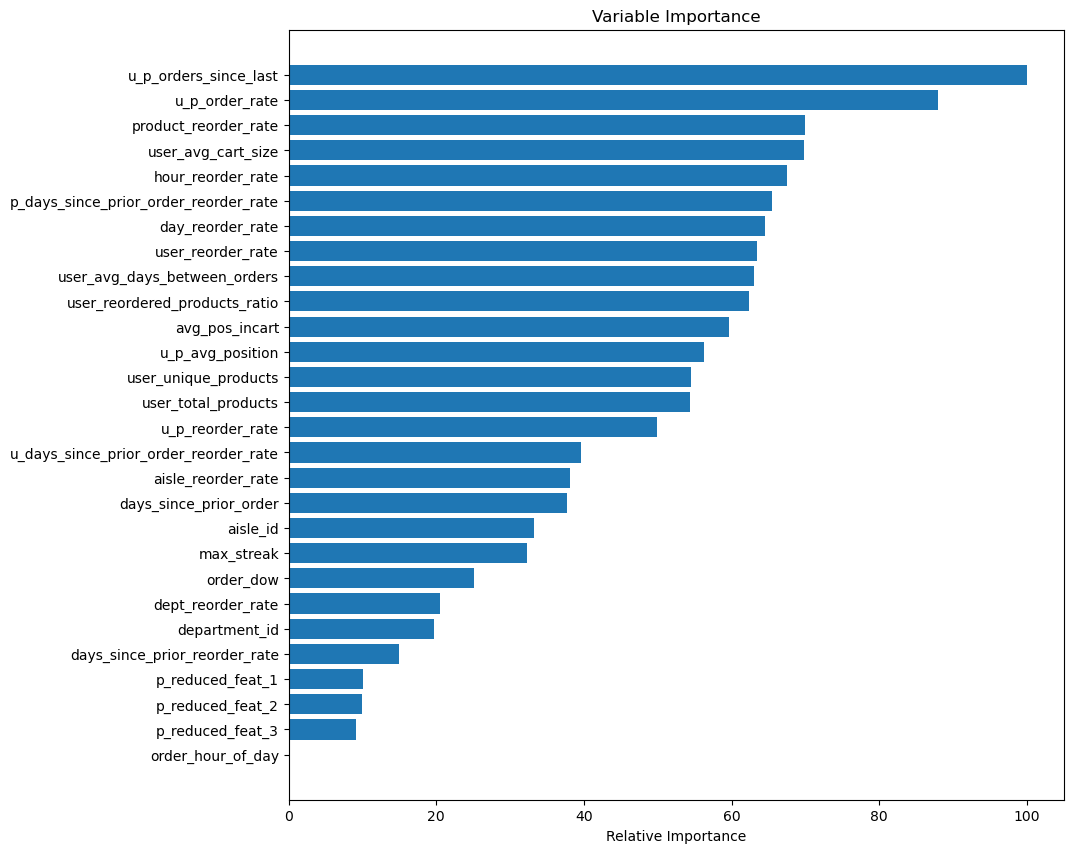

CPU times: total: 1h 19min 2s
Wall time: 12min 16s


In [14]:
%%time
#clf.fit(X_train, y_train)
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


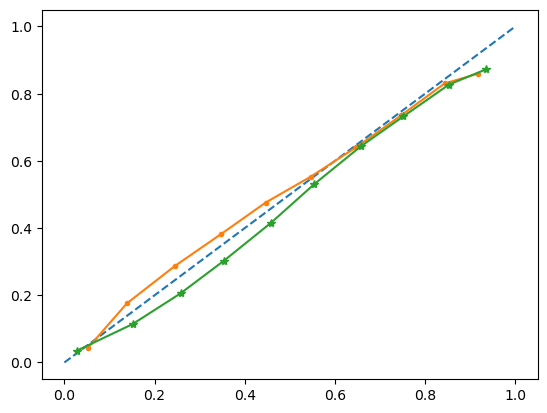

In [74]:
""" Reliability Diagrams  - Calibration curves
Ref: https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/
the loser the points will appear along the main diagnoal from left to the right, the bettter the calibration.
 when the position of the points  or curve relative to the diagonal helps to interpret the probabilities:
   Below the diagonal : model has over forecast
   Above the diagonal : model has under-forecast 

In the below diagram probability curve is drawn with(orange) and without calibration (green)
  green curve shows that model has over forecast without calibration 

"""
fop, mpv = calibration_curve(y_test,predict_y[:,1],n_bins =10)
fop1, mpv1 = calibration_curve(y_test,predict_y1[:,1],n_bins =10)
pyplot.plot([0,1],[0,1], linestyle='--')
pyplot.plot(mpv,fop,marker ='.')
pyplot.plot(mpv1,fop1,marker ='*')
pyplot.show()

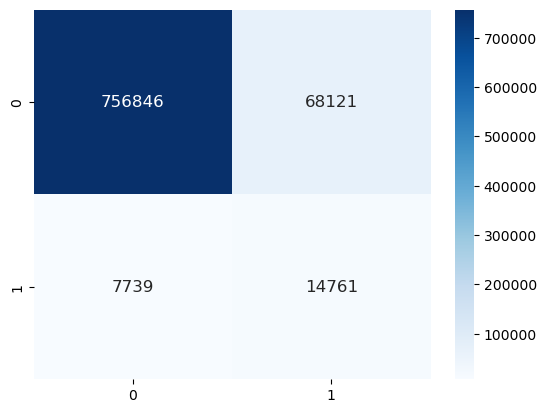

[[756846  68121]
 [  7739  14761]]
Accuracy : 0.9104861900227383
Precision : 0.6560444444444444
CPU times: total: 2.55 s
Wall time: 2.79 s


In [27]:
%%time
cm = confusion_matrix(np.argmax(predict_y,1),y_test)
sns.heatmap(cm, cmap='Blues', annot = True, fmt="g", annot_kws={"size": 12})
plt.show()
print(cm)
print("Accuracy :",accuracy_score(y_test, np.argmax(predict_y,1)))
print("Precision :",precision_score(y_test, np.argmax(predict_y,1)))





###### With subset of features False Positive value increased True positive value was decreased . Less features is showing lower performance compared to selecting all features. So we will keep all features as of now for testing purpsoe

In [100]:
%%time
# run the model with subset of features
X_train_subset = X_train.drop(columns =['u_p_orders_since_last','u_p_order_rate','product_reorder_rate','user_avg_cart_size','hour_reorder_rate','p_days_since_prior_order_reorder_rate'])
X_test_subset = X_test.drop(columns =['u_p_orders_since_last','u_p_order_rate','product_reorder_rate','user_avg_cart_size','hour_reorder_rate','p_days_since_prior_order_reorder_rate'])
clf=RandomForestClassifier(n_estimators=25, random_state= 42, n_jobs = -1)
clf.fit(X_train_subset, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_subset, y_train)
predict_y1 = clf.predict_proba(X_test_subset)
predict_y = sig_clf.predict_proba(X_test_subset)
print("logloss on validation data :",log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))

logloss on validation data : 0.2684217465775835


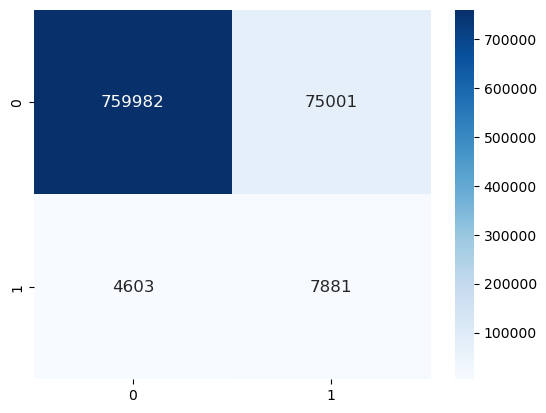

[[759982  75001]
 [  4603   7881]]
Accuracy : 0.9060683188843931
Precision : 0.631288048702339
CPU times: total: 2.42 s
Wall time: 2.66 s


In [101]:
%%time
cm = confusion_matrix(np.argmax(predict_y,1),y_test)
sns.heatmap(cm, cmap='Blues', annot = True, fmt="g", annot_kws={"size": 12})
plt.show()
print(cm)
print("Accuracy :",accuracy_score(y_test, np.argmax(predict_y,1)))
print("Precision :",precision_score(y_test, np.argmax(predict_y,1)))

### Decision Tree


In [10]:
%%time

param_grid = {}
param_grid['max_depth'] = [5,10,15,20]
param_grid['min_samples_split'] = [2,3,4,5]

dt_clf = DecisionTreeClassifier()
r_search = RandomizedSearchCV(dt_clf, param_distributions=param_grid, cv = 5, verbose = True, n_jobs = -1)
r_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: total: 7min 33s
Wall time: 8h 39min 5s


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20],
                                        'min_samples_split': [2, 3, 4, 5]},
                   verbose=True)

In [11]:
r_search.best_params_

{'min_samples_split': 4, 'max_depth': 10}

In [42]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4833292 entries, 0 to 4833291
Data columns (total 34 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   user_id                                int32  
 1   product_id                             uint16 
 2   u_p_order_rate                         float16
 3   u_p_reorder_rate                       float16
 4   u_p_avg_position                       float16
 5   u_p_orders_since_last                  int8   
 6   max_streak                             int8   
 7   user_reorder_rate                      float16
 8   user_unique_products                   int16  
 9   user_total_products                    int16  
 10  user_avg_cart_size                     float16
 11  user_avg_days_between_orders           float16
 12  user_reordered_products_ratio          float16
 13  product_reorder_rate                   float16
 14  avg_pos_incart                         float16
 15  p_r

logloss on validation data : 0.25103457457139833


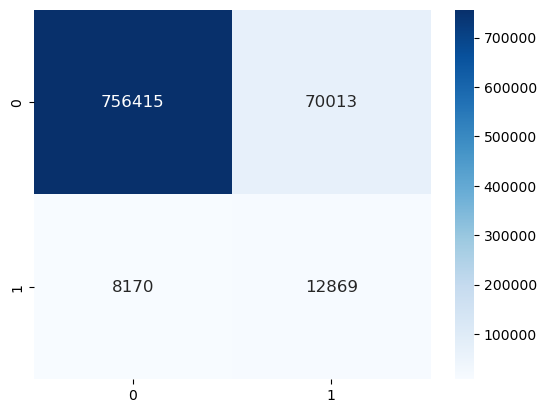

[[756415  70013]
 [  8170  12869]]
Accuracy : 0.9077450803394115
Precision : 0.6116735586292125
CPU times: total: 4.28 s
Wall time: 4.46 s


In [14]:
%%time
predict_y = r_search.predict_proba(X_test)
print("logloss on validation data :",log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))

cm = confusion_matrix(np.argmax(predict_y,1),y_test)
sns.heatmap(cm, cmap='Blues', annot = True, fmt="g", annot_kws={"size": 12})
plt.show()
print(cm)
print("Accuracy :",accuracy_score(y_test, np.argmax(predict_y,1)))
print("Precision :",precision_score(y_test, np.argmax(predict_y,1)))

#### Testing Time : Lets check what is the probability of users ordering the products and what recommendation can be given to users

Let check out what products will be recommended to user id = 1109


In [34]:
user_products_probability = pd.merge(test_data[['user_id','product_id','probability']],products, on='product_id', how = 'inner')
user_products_probability = user_products_probability[['user_id','product_name','probability']]
#productList = test_data[test_data['user_id'] == 2291].sort_values(by='probability', ascending = False).head(10)[['user_id','product_id','probability']]
productList = user_products_probability[user_products_probability['user_id'] == 2291].sort_values(by='probability', ascending = False).head(5)

print(productList)

         user_id                                   product_name  probability
1638294     2291                         Pulp Free Orange Juice     0.600554
380184      2291                           Organic Baby Arugula     0.441127
362303      2291                            Large Alfresco Eggs     0.337189
1686757     2291  Organic Gluten & Wheat Free Homestyle Waffles     0.300003
276460      2291                                          Limes     0.293124


In [39]:
prior_train_order[prior_train_order['user_id'] == 2291].groupby('product_name')['product_name'].count().reset_index(name = 'prd_cnt').sort_values(by = 'prd_cnt',ascending = False).head(5)

NameError: name 'prior_train_order' is not defined

In [38]:
user_products_probability_subset = pd.merge(test_data[['user_id','product_id','probability']],products, on='product_id', how = 'inner')
user_products_probability_subset = user_products_probability_subset[['user_id','product_name','probability']]
#productList = test_data[test_data['user_id'] == 2291].sort_values(by='probability', ascending = False).head(10)[['user_id','product_id','probability']]
productList = user_products_probability_subset[user_products_probability_subset['user_id'] == 1109].sort_values(by='probability', ascending = False).head(5)

print(productList)

         user_id                              product_name  probability
2665018     1109  Blue Machine Boosted 100% Juice Smoothie     0.493625
439333      1109                        Organic Spring Mix     0.296667
2018060     1109                            Collard Greens     0.254348
14947       1109                               Green Beans     0.210516
1234584     1109                    Organic Bagged Carrots     0.193324


In [1]:
productList = user_products_probability[user_products_probability['user_id'] == 206191].sort_values(by='probability', ascending = False)#.head(5)
print(productList)

NameError: name 'user_products_probability' is not defined

In [ ]:
productList = user_products_probability[user_products_probability['user_id'] == 206191].sort_values(by='probability', ascending = False)#.head(5)
print(productList)

In [ ]:
###dont look down.........

In [82]:
test_data['user_id'].head(6)

0       3
1      12
2     418
3     503
4     720
5    1096
Name: user_id, dtype: int32

In [109]:
user1109 = prior_train_order[prior_train_order['user_id'] == 112108]
user1109 =  user1109.groupby('product_name')['product_name'].count().reset_index(name = 'No_of_Orders')
#print(user1109[['user_id','product_name']])
print(user1109.sort_values(by = 'No_of_Orders', ascending = False).head(5))

NameError: name 'prior_train_order' is not defined

In [100]:
prior_train_order[prior_train_order['user_id'] == 1109].to_csv('userdatacec.csv')

In [ ]:
prior_orders_data[prior_orders_data['user_id'] == 1109].to_csv('userdatacectesting.csv')

In [44]:
%%time

data = train_data.drop(['user_id', 'product_id', 'order_id','reordered'], axis = 1)

ypred_proba = sig_clf.predict_proba(data)
ypred1 = sig_clf.predict(data)
train_data['reordered_2'] = ypred1
#get probabilities of class 1
ypred = ypred_proba[:,-1]
train_data['reordered_1'] = np.argmax(ypred_proba,1) 

train_data['probability'] = ypred_proba[:,-1]


CPU times: total: 56min 1s
Wall time: 19min 2s


In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15254389 entries, 2690675 to 1484917
Data columns (total 28 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   u_p_order_rate                         float16
 1   u_p_reorder_rate                       float16
 2   u_p_avg_position                       float16
 3   u_p_orders_since_last                  int8   
 4   max_streak                             int8   
 5   user_reorder_rate                      float16
 6   user_unique_products                   int16  
 7   user_total_products                    int16  
 8   user_avg_cart_size                     float16
 9   user_avg_days_between_orders           float16
 10  user_reordered_products_ratio          float16
 11  product_reorder_rate                   float16
 12  avg_pos_incart                         float16
 13  p_reduced_feat_1                       float16
 14  p_reduced_feat_2                       float16
 

In [ ]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [116]:
feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx

array([21, 15, 13, 14, 17, 20, 19, 27, 16, 26, 18, 22,  2, 24, 10, 23, 25,
        6,  9, 12,  7,  5,  4, 11,  8,  1,  0,  3], dtype=int64)

In [4]:
 Cv_rfc.best_params_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

In [ ]:
def model_stats(predict_y,y_val):# Plot confusion Matrix

  """
  Display model statistics such as accuracy , precision score and confusion matrix
  """

  #predicted_y =np.array(predict_y>0.5,dtype=int).reshape(-1,).tolist()
  cm = confusion_matrix(y_val, predict_y)
  sns.heatmap(cm, cmap='Blues', annot = True, fmt="g", annot_kws={"size": 12})
  plt.show()
  print("Accuracy :",accuracy_score(y_val, predict_y))
  print("Precision :",precision_score(y_val, predict_y))

In [43]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4833292 entries, 0 to 4833291
Data columns (total 31 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   user_id                                int32  
 1   product_id                             uint16 
 2   u_p_order_rate                         float16
 3   u_p_reorder_rate                       float16
 4   u_p_avg_position                       float16
 5   u_p_orders_since_last                  int8   
 6   max_streak                             int8   
 7   user_reorder_rate                      float16
 8   user_unique_products                   int16  
 9   user_total_products                    int16  
 10  user_avg_cart_size                     float16
 11  user_avg_days_between_orders           float16
 12  user_reordered_products_ratio          float16
 13  product_reorder_rate                   float16
 14  avg_pos_incart                         float16
 15  p_r

In [348]:
test_data = test_orders_merge_df[['user_id', 'product_id', 'order_id']]
ypred = sig_clf.predict_proba(data)
      #get probabilities of class 1
ypred = ypred[:,-1]
test_data['reordered'] =  ypred       
 
#create a dataframe with orderID and list of all possible productID's
test_products = test_data.groupby(['order_id'])['product_id'].apply(list).reset_index()
    
    #collect all probs in a single list for each OrderID
probs = test_data.groupby(['order_id'])['reordered'].apply(list).reset_index()
test_products['probs'] = probs['reordered']

In [123]:
test_data['user_id'].head(40)

,user_id,product_id,probability
0,3,248,0.038445
1,12,248,0.051726
2,418,248,0.043123
3,503,248,0.036652
4,720,248,0.077739
5,1096,248,0.053266
6,1109,248,0.047820
7,1111,248,0.064548
8,1261,248,0.040613
9,1409,248,0.038573


#### K-Means Clustering Model selection process to determins the best value of k
 The goal here to identify the optimal value of k that balalnces model performances between underfitting and overfitting. 
 Scaling is important because KNN relies on distance metrics and havign features on different scales can affect the 
 algorithm's performance 
 

C:\Users\Pallavi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Pallavi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Pallavi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Pallavi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the 

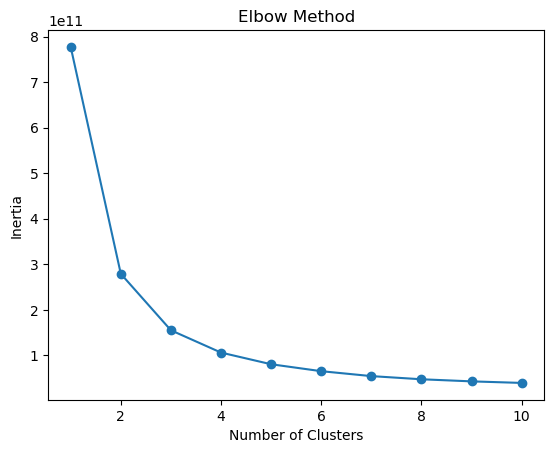

CPU times: total: 2h 10min 16s
Wall time: 33min 39s


In [3]:
%%time

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

inertia = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X_train)  # X is your data
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()
    

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
for n_clusters in range(2,11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(X_train)  # X is your data
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

In [32]:
%%timX_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7627194 entries, 7249036 to 6580096
Data columns (total 29 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   u_p_order_rate                         float16
 1   u_p_reorder_rate                       float16
 2   u_p_avg_position                       float16
 3   u_p_orders_since_last                  int8   
 4   max_streak                             int8   
 5   user_reorder_rate                      float16
 6   user_unique_products                   int16  
 7   user_total_products                    int16  
 8   user_avg_cart_size                     float16
 9   user_avg_days_between_orders           float16
 10  user_reordered_products_ratio          float16
 11  product_reorder_rate                   float16
 12  avg_pos_incart                         float16
 13  p_reduced_feat_1                       float16
 14  p_reduced_feat_2                       float16
 1

In [50]:
%%time
kmeans = KMeans(n_clusters = 4)

clusterer = kmeans.fit(X_train)
cluster_centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_

# Create a DataFrame to store cluster centroids and feature names
cluster_features = pd.DataFrame(cluster_centers, columns=X_train.columns)

X_train['ClustersId'] = cluster_labels
for i in range(kmeans.n_clusters):
    print(f"Cluster {i} - Best Features:")
    
    # Get the top N features with the highest centroids for the cluster
    top_n_features = cluster_features.iloc[i].nlargest(4)
    
    # Print the top N features for the cluster
    print(top_n_features)



C:\Users\Pallavi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0 - Best Features:
user_total_products      707.774658
user_unique_products     209.710495
aisle_id                  71.137024
u_p_orders_since_last     20.059647
Name: 0, dtype: float32
Cluster 1 - Best Features:
user_total_products      1282.571167
user_unique_products      290.279480
aisle_id                   71.274277
u_p_orders_since_last      25.683264
Name: 1, dtype: float32
Cluster 2 - Best Features:
user_total_products       109.005722
aisle_id                   70.946693
user_unique_products       61.386120
days_since_prior_order     17.853384
Name: 2, dtype: float32
Cluster 3 - Best Features:
user_total_products     350.552582
user_unique_products    140.620972
aisle_id                 71.122215
user_avg_cart_size       13.630077
Name: 3, dtype: float32
CPU times: total: 9min 42s
Wall time: 2min 30s


In [122]:
%%time
data = test_data.drop(['user_id', 'product_id', 'order_id'], axis = 1)
kmean_predict = clusterer.predict(X_test)
X_test['ClustersId'] = kmean_predict

kmean_predict = clusterer.predict(data)
test_data['ClustersId'] = kmean_predict

KeyError: "['order_id'] not found in axis"

In [121]:
test_data

,user_id,product_id,probability
0,3,248,0.038445
1,12,248,0.051726
2,418,248,0.043123
3,503,248,0.036652
4,720,248,0.077739
...,...,...,...
4833287,205877,27049,0.043182
4833288,205880,25635,0.058200
4833289,205893,11873,0.040386
4833290,206131,12653,0.166073


In [57]:
print('Check users')
#print(X_test[X_test['user_id'] == 39279])
X_test_reset = X_test.reset_index()

cluster_labels_df = pd.DataFrame(kmean_predict, columns=['Cluster_Labels'])

# Concatenate X_test_reset and cluster_labels_df
merged_test = pd.concat([X_test_reset, cluster_labels_df], axis=1)

result = pd.merge(merged_test, train_x_users, left_index=True, right_index=True)

print(result[result['user_id'] == 39279])




Check users
Empty DataFrame
Columns: [index, u_p_order_rate, u_p_reorder_rate, u_p_avg_position, u_p_orders_since_last, max_streak, user_reorder_rate, user_unique_products, user_total_products, user_avg_cart_size, user_avg_days_between_orders, user_reordered_products_ratio, product_reorder_rate, avg_pos_incart, p_reduced_feat_1, p_reduced_feat_2, p_reduced_feat_3, aisle_id, department_id, aisle_reorder_rate, dept_reorder_rate, order_dow, order_hour_of_day, days_since_prior_order, hour_reorder_rate, day_reorder_rate, p_days_since_prior_order_reorder_rate, u_days_since_prior_order_reorder_rate, days_since_prior_reorder_rate, Cluster_Labels, user_id, product_id, reordered]
Index: []

[0 rows x 33 columns]


In [ ]:
colors = ['orange','blue','purple','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[4],tocluster[1],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [344]:
predict_y

array([[9.99999332e-01, 6.67705109e-07],
       [9.99999332e-01, 6.67705109e-07],
       [9.99999332e-01, 6.67705109e-07],
       ...,
       [9.99999332e-01, 6.67705109e-07],
       [9.99999332e-01, 6.67705109e-07],
       [9.99999332e-01, 6.67705109e-07]])

In [351]:
test_data.sort_values(by = 'reordered', ascending = False).head(4)

,user_id,product_id,order_id,reordered
3965489,192671,9551,3270960,0.999994
4533407,47266,6119,2779171,0.999994
4094760,10103,42078,1753072,0.999994
2076702,141890,45123,281675,0.999994


In [359]:
orders[orders['user_id'] == 192671 ]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
3195367,240843,192671,prior,1,4,16,NaN
3195368,1291723,192671,prior,2,3,12,6.0
3195369,2625385,192671,prior,3,5,14,9.0
3195370,2544571,192671,prior,4,3,12,5.0
3195371,3079543,192671,prior,5,1,17,5.0
3195372,2163848,192671,prior,6,6,14,26.0
3195373,1220663,192671,prior,7,5,16,20.0
3195374,1932836,192671,prior,8,0,15,16.0
3195375,3169564,192671,prior,9,3,16,10.0
3195376,3199073,192671,prior,10,6,12,10.0


In [352]:
test_data[test_data['user_id'] == 192671].sort_values(by = 'reordered', ascending = False).head(4)

,user_id,product_id,order_id,reordered
4719299,192671,5724,3270960,0.999994
3965489,192671,9551,3270960,0.999994
3413376,192671,45930,3270960,0.999994
1930881,192671,277,3270960,0.999994


In [354]:
orders[orders['order_id'] == 3270960 ]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
3195391,3270960,192671,test,25,2,12,5.0


In [11]:
prior_order[prior_order['order_id'] == 3185580 ].sort_values(by='product_id', ascending = False)

,order_id,product_id,add_to_cart_order,reordered
30199738,3185580,45930,2,1
30199748,3185580,43889,12,0
30199744,3185580,39190,8,1
30199749,3185580,35042,13,0
30199751,3185580,32810,15,0
30199742,3185580,28204,6,1
30199750,3185580,24710,14,1
30199740,3185580,15618,4,1
30199747,3185580,14410,11,1
30199737,3185580,13249,1,1


In [235]:
user_reorder_rate = prior_train_order.groupby(["user_id","reordered"])['reordered'].count().groupby(level = 0).\
apply(lambda x: x / float(x.sum())).\
 reset_index(level=1, drop=True).\
reset_index(name='reorder_rate')

In [221]:
user_reorder_rate = prior_train_order.groupby(["user_id","reordered"])['reordered'].count().\
                     groupby(level = 0).apply(lambda x: x / float(x.sum())).\
                     reset_index(level=1, drop=True)
  

In [236]:
user_reorder_rate.head(3)

,user_id,reordered,reorder_rate
0,1,0,0.271429
1,1,1,0.728571
2,2,0,0.535398


In [229]:
user_reorder_rate = user_reorder_rate.unstack().reset_index()
user_

In [ ]:
%%time
product_features = generate_product_features(prior_data = prior_orders_data )
product_features.to_csv("product_features_v6.csv",index=False)


In [310]:
#user_reorder_rate = user_reorder_rate.unstack().reset_index()
#user_reorder_rate = user_reorder_rate.set_index(['user_id', 'reordered'])['reorder_rate'].unstack().reset_index()
user_reorder_rate = user_reorder_rate.pivot(index ='user_id', columns ='reordered', values =['reorder_rate']) 
user_reorder_rate = pd.DataFrame(user_reorder_rate.to_records())
user_reorder_rate.columns = ['user_id','0', '1']
user_reorder_rate.set_index("user_id", inplace = True)
user_reorder_rate.fillna(0, inplace = True)
user_reorder_rate.reset_index(inplace = True)
user_features['user_reorder_rate'] = user_reorder_rate['1']

KeyError: 'reordered'

In [135]:
X = ipr.drop(columns =['reordered',
       'order_id'     
       ])
y = ipr['reordered']
# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Define your XGBoost model
model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)


d_train = xgboost.DMatrix(X_train,y_train)
# Fit the model to your training data
model.fit(X_train, y_train)

xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}
watchlist= [(d_train, "train")]

bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=80, evals=watchlist, verbose_eval=10)

xgboost.plot_importance(bst)




ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:product_name: object

In [ ]:
def generate_user_features(prior_data = None):
    #create an empty dataframe
    user_features = pd.DataFrame(columns=['user_id'])

In [ ]:
d_test = xgboost.DMatrix(X_test,y_test)
#bst = xgboost.train(params=xgb_params, dtest=d_test, num_boost_round=80, evals=watchlist, verbose_eval=10)
y_prediction = bst.predict(d_test)
                      
                         

In [136]:
ipr.eval_set.value_counts()

AttributeError: 'DataFrame' object has no attribute 'eval_set'

In [133]:
X_test =  pd.read_csv('../data/sample_submission.csv')
X_test['reordered'] = 0
y_test = X_test['reordered']
d_test = xgboost.DMatrix(X_test.drop(columns=['reordered']),y_test)
#bst = xgboost.train(params=xgb_params, dtest=d_test, num_boost_round=80, evals=watchlist, verbose_eval=10)
X_test.loc[:'reordered'] = bst.predict(d_test)
X_test.to_csv('results.csv')                        
                         
                         


ValueError: feature_names mismatch: ['order_id', 'product_id', 'add_to_cart_order', 'aisle_id', 'department_id', 'user_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'max_purchasecount', 'most_ordered_product_id'] ['order_id', 'user_id', 'product_id']
expected order_hour_of_day, order_number, order_dow, department_id, max_purchasecount, add_to_cart_order, aisle_id, most_ordered_product_id, days_since_prior_order in input data

In [126]:
train_dataset.head(10)

,order_id,user_id,product_id
0,17,39276,29259
1,34,39276,29259
2,137,39276,29259
3,182,39276,29259
4,257,39276,29259
5,313,39276,29259
6,353,39276,29259
7,386,39276,29259
8,414,39276,29259
9,418,39276,29259


In [ ]:
d_test = xgboost.train(params = xgb_params,dtrain = d_train, num_boost_round = 80, evals = watchlist, verbose_eval=10)
prediction_Set= bst.predict(d_test) 

In [111]:
ipr.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
       'product_name', 'aisle_id', 'department_id', 'user_id', 'order_number',
       'order_dow', 'order_hour_of_day', 'days_since_prior_order',
       'max_purchasecount', 'most_ordered_product_id', 'max_ord_cnt'],
      dtype='object')